# Primeiros Passos: Data Analytics e IA

A Ideia central do projeto é coletar os dados dos clientes vinculados aos planos geridos pela Odontoprev. Queremos entender se a idade dessas pessoas, gênero, cidade/estado, tipo do plano, onde residem influenciam na forma como elas matém o cuidado com a saúde bucal. Além disso, dados básicos como frequência com que vai ao dentista, quais procedimentos realiza, quais tratamentos já realizou precisam estar nesses dados para tentarmos classificar o grau de risco que esse usuário tem para sinistros curativos que são de 3 a 5 vezes mais custosos para a Odontoprev. Importamos uma base com dados ficticios das tabelas do banco de dados desenhado para este projeto, a fim de começar a traçar quais labels são importantes e qual método de análise usaremos. A principio, decidimos utilizar a classificação de testar os modelos Random Forest e . Temos um longo caminho pelo frente e a próxima sprint será decisiva para qual solução de Data Analytics entregaremos para este projeto.



In [53]:
#importação das bibliotecas necessárias para as análises, treinamentos, gráficos e previsões:

import pandas as pd
import numpy as np

#Plotar gráficos para entender dados:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

# O pacote warnings inibe a visualização de avisos nos outputs do Colab:
import warnings
warnings.filterwarnings('ignore')

# Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier

#Importação modelo Random Forest Classificação:
from sklearn.ensemble import RandomForestClassifier

# Conversão de dados categóricos em numéricos:
from sklearn.preprocessing import LabelEncoder

# Normalização dos dados:
from sklearn.preprocessing import StandardScaler

# Divisão dos dados em treino e teste:
from sklearn.model_selection import train_test_split

# Pacote para cálculo da acurácia do modelo de classificação:
from sklearn.metrics import accuracy_score

# Métrica de avaliação para modelos de clustering:
from sklearn.metrics import silhouette_score

In [11]:
# Carregar o arquivo Excel
dados = pd.read_excel('dados_trat_odonto.xlsx')

# Exibir as primeiras linhas do DataFrame
print(dados.head())


   ID_CLIE DT_CADASTRO                   NM_CLIE    DT_NASC GENERO  \
0        1  2022-08-31    Fernando Vilares Silva 1984-12-06      M   
1       10  2023-03-23     Ronilda Pedroso Gomes 1980-01-29      F   
2        2  2022-07-15  Caroline Andrade Correia 1996-03-24      F   
3        3  2024-11-08                João Silva 1990-05-10      M   
4        4  2023-01-30   Ronaldo Souza Goncalves 1988-02-10      M   

                       EMAIL  TB_ENDERECO_ID_END  TB_PLANO_ID_PLANO  \
0        fernandov@email.com                   2                  1   
1  nilda_pedrosa80@gmail.com                  10                 10   
2    carol_gatinha@email.com                   1                  2   
3      joao.silva@update.com                   1                  2   
4     ronaldinho10@gmail.com                   4                  4   

   ID_ATENDIMENTO DT_ATENDIMENTO  \
0             1.0     2023-08-12   
1            10.0     2023-07-18   
2             2.0     2023-09-14   
3       

In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_CLIE             21 non-null     int64         
 1   DT_CADASTRO         21 non-null     datetime64[ns]
 2   NM_CLIE             21 non-null     object        
 3   DT_NASC             21 non-null     datetime64[ns]
 4   GENERO              20 non-null     object        
 5   EMAIL               21 non-null     object        
 6   TB_ENDERECO_ID_END  21 non-null     int64         
 7   TB_PLANO_ID_PLANO   21 non-null     int64         
 8   ID_ATENDIMENTO      16 non-null     float64       
 9   DT_ATENDIMENTO      16 non-null     datetime64[ns]
 10  DIAGNOSTICO         16 non-null     object        
 11  ID_PROC             16 non-null     float64       
 12  NM_PROC             16 non-null     object        
 13  TP_PROC             16 non-null     object        
 

In [13]:
# Definindo em quantas vezes quero duplicar o dataset carregado
fator_aumento = 10

# Gerando cópias do dataset original com ruído aleatório nas colunas numéricas
dados_expandido = pd.concat([dados] * fator_aumento, ignore_index=True)
colunas_numericas = dados.select_dtypes(include=np.number).columns

for coluna in colunas_numericas:
    dados_expandido[coluna] += np.random.normal(0, dados[coluna].std() * 0.1, size=dados_expandido.shape[0]


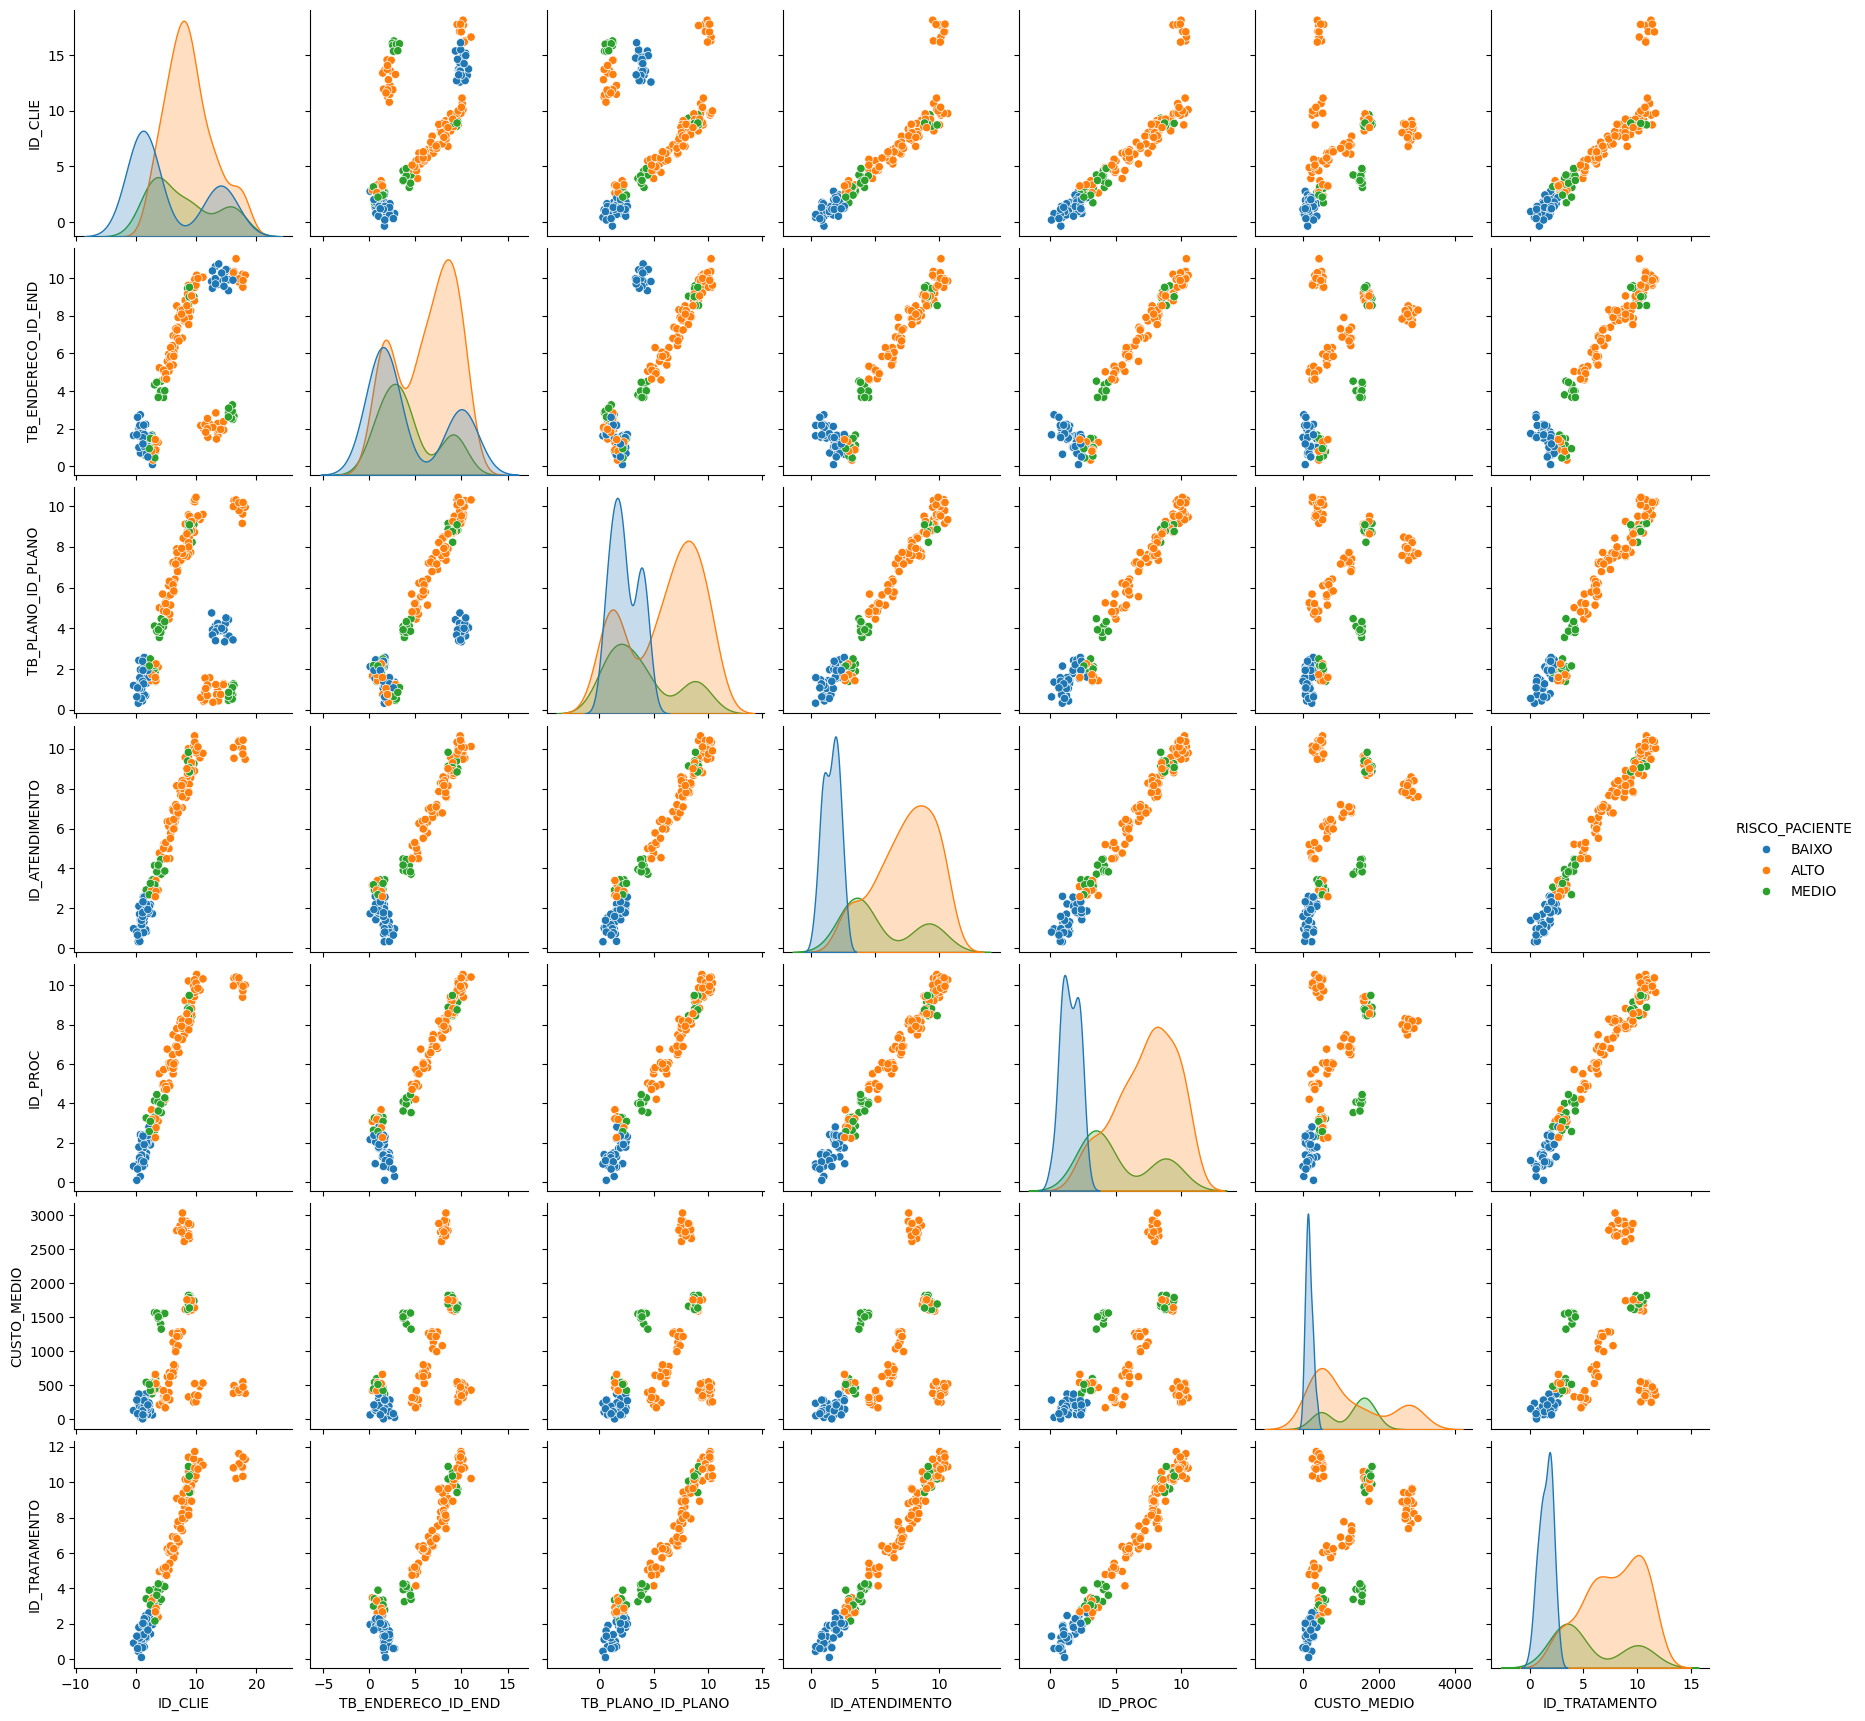

In [16]:
#Como cada coluna do dataset parece se relacionar com a coluna target "RISCO_PACIENTE"
sns.pairplot(dados_expandido, hue='RISCO_PACIENTE')

In [14]:
dados_expandido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_CLIE             210 non-null    float64       
 1   DT_CADASTRO         210 non-null    datetime64[ns]
 2   NM_CLIE             210 non-null    object        
 3   DT_NASC             210 non-null    datetime64[ns]
 4   GENERO              200 non-null    object        
 5   EMAIL               210 non-null    object        
 6   TB_ENDERECO_ID_END  210 non-null    float64       
 7   TB_PLANO_ID_PLANO   210 non-null    float64       
 8   ID_ATENDIMENTO      160 non-null    float64       
 9   DT_ATENDIMENTO      160 non-null    datetime64[ns]
 10  DIAGNOSTICO         160 non-null    object        
 11  ID_PROC             160 non-null    float64       
 12  NM_PROC             160 non-null    object        
 13  TP_PROC             160 non-null    object        

In [44]:
# Escolhendo as colunas preditivas e alvo. Tivemos que excluir algumas colunas que achamos importantes devido não ser possível transformá-las
# em numéricas, são categóricas e com grandes cadeias de texto.
#Para a próxima entrega precisaremos rever como incluir essas colunas em nosso modelo, pois certamente podem influenciar no resultado

X = dados_expandido.drop(columns = ['RISCO_PACIENTE', 'NM_CLIE', 'EMAIL','DESC_TRATAMENTO','TB_PLANO_ID_PLANO', 'NM_PROC', 'DIAGNOSTICO','DT_CADASTRO', 'DT_NASC', 'DT_ATENDIMENTO']) # Somente Comprimento do Abdômen e Comprimento das Antenas
y = dados_expandido['RISCO_PACIENTE']                # Classe alvo


In [45]:
# Convertendo colunas categóricas para variáveis numéricas
X = pd.get_dummies(X)

In [46]:
# Dividindo conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 8)

In [47]:
#Treinando o Classificador
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train) # Treinamos o classificador passando apenas o conjunto de dados de treinamento

#Teste
y_predicoes = rf.predict(X_test)

# Metricas de precisão, revocação, f1-score e acurácia. Vemos que o modelo devido ter poucas labels e poucos dados teve um provável
#overfit. Precisamos entender melhor esses dados, possivelmente se não tivermos fontes de dados confiáveis sobre os cliente da empresa
#precisaremos tratar esses dados com dashboards analíticos resultado de uma boa análise de dados feita com SQL, Excel, Power BI, Pandas, etc.
print(classification_report(y_test, y_predicoes))

              precision    recall  f1-score   support

        ALTO       1.00      0.95      0.98        21
       BAIXO       1.00      1.00      1.00        10
       MEDIO       0.92      1.00      0.96        11

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



Aqui plotamos uma matriz de confusão para averiguar se o modelo errou algum alvo e quais foram. ele classificou apenas um dado erroneamente, de alto como médio, devido ao provável overfitting do modelo.

<Figure size 1500x500 with 0 Axes>

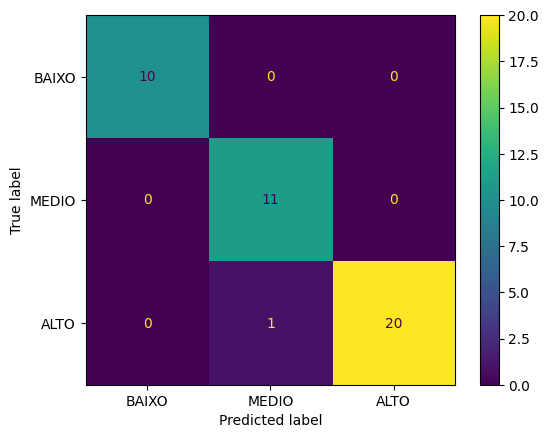

In [43]:
matriz_confusao = confusion_matrix(y_true = y_test,
                                   y_pred = y_predicoes,
                                   labels=['BAIXO','MEDIO','ALTO'])

# plotando uma figura com a matriz de confusao
figure = plt.figure(figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao,
                              display_labels=['BAIXO','MEDIO','ALTO'])
disp.plot(values_format='d')

In [55]:
#Treinando outro classificador: arvore de decisão
modelo_tree = DecisionTreeClassifier(random_state= 42)
modelo_tree.fit(X_train, y_train)

#Testando o Classificador
y_predicoes = modelo_tree.predict(X_test)

# Metricas de precisão, revocação, f1-score e acurácia.
print(classification_report(y_test, y_predicoes))

              precision    recall  f1-score   support

        ALTO       0.91      1.00      0.95        21
       BAIXO       1.00      1.00      1.00        10
       MEDIO       1.00      0.82      0.90        11

    accuracy                           0.95        42
   macro avg       0.97      0.94      0.95        42
weighted avg       0.96      0.95      0.95        42



# Conclusão


Diferentemente do Random Forest, o Decision Tree apresentou 2 erros porém em outra classe: Risco Médio. Mais uma vez podemos perceber que devido às limitações atuais de converter grandes strings de texto em labels numéricas, tivemos que excluí-las e possivelmente isso deu um overfit no modelo. Para a próxima Sprint a ideia é ser mais disruptivo e testar outros tipos de modelo caso haja dados suficientes e confiáveis para tal. Se não houver, iremos focar em trazer uma análise de dados bem embasada e visual para aportar às tomadas de decisão da Odontoprev.

<Figure size 1500x500 with 0 Axes>

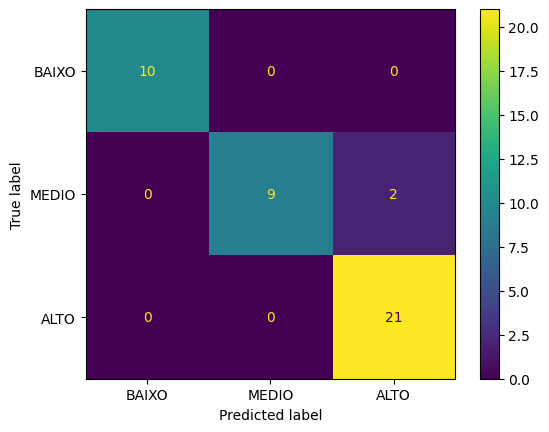

In [56]:
matriz_confusao = confusion_matrix(y_true = y_test,
                                   y_pred = y_predicoes,
                                   labels=['BAIXO','MEDIO','ALTO'])

# plotando uma figura com a matriz de confusao
figure = plt.figure(figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao,
                              display_labels=['BAIXO','MEDIO','ALTO'])
disp.plot(values_format='d')